# Analysis of Output
After running a trial, I move all output to its own directory, e.g. `build/src/trial_smallB_n064`.

- The suffix "`_rev`" indicates that the initial velocity was reversed (equivalent to negating the magnetic field). This is expected to reduce stability.
- The suffix "`_old`" indicates that the initial velocity was miscalculated to be inward along y and outward along z
- The suffix "`_start`" indicates that only t=0 is available
- The suffix "`_fromphi`" indicates that the electric field was calculated from the given potential (otherwise, the trial simply used the given field)
- The prefix "`bug`" indicates that the interpolation was bugged (mixed-up weights)
- The number after `n` (064 above) is the number of grid cells per axis.
- The number after `N` is the number of steps done (`psc_params.nmax`), e.g. 30k. Default is 5k.
- B is the transverse magnetic field, given by the following:

| Size | Value |
| :-   | :-:   |
| small| .1    |
|med   | 1     |
|big   | 10    |

In [2]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import viscid
viscid.calculator.evaluator.enabled = True
from viscid.plot import vpyplot as vlt

import os
import ipywidgets as widgets
from IPython.display import display

%config InlineBackend.figure_format = 'retina'

ModuleNotFoundError: No module named 'viscid'

In [4]:
# where the data is
trialpath="/Users/james/Code/cpp/PSC/psc/build/src"

# which data to use
all_files = os.listdir(trialpath)
valid_trialfiles = sorted([file for file in all_files if "trial_" in file])

if "pfd.xdmf" in all_files:
    valid_trialfiles = ["."] + valid_trialfiles

trialfile = valid_trialfiles[0]

w = widgets.Dropdown(
    options=valid_trialfiles,
    value=trialfile,
    description='Trial file:',
    disabled=False,
)

def on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        global trialfile
        trialfile = change['new']

w.observe(on_change)

display(w)

ModuleNotFoundError: No module named 'ipywidgets'

## Fields and Current
- `hx_fc` at t=1 is pretty cool for small B
- `jy_ec` and `jz_ec` precess at a rate proportional to B
- magnetic field is always cool, albeit unenlightening

Trial: .
['jx_ec', 'jy_ec', 'jz_ec', 'ex_ec', 'ey_ec', 'ez_ec', 'hx_fc', 'hy_fc', 'hz_fc']
t = 0.0


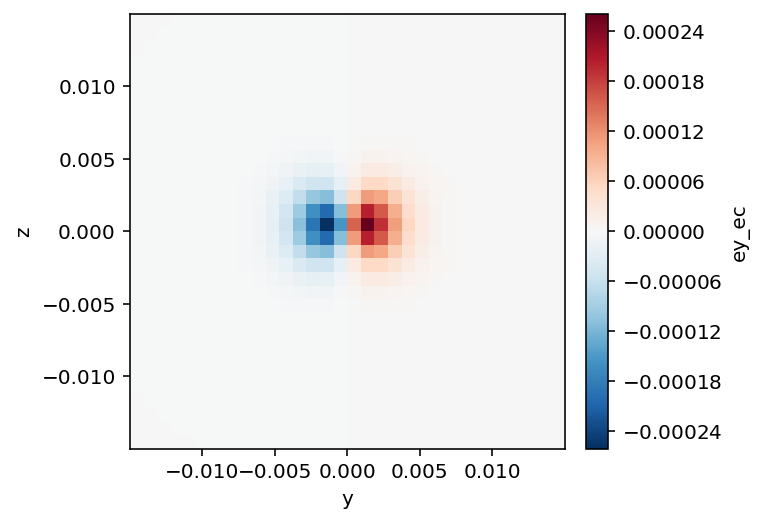

In [13]:
print(f"Trial: {trialfile}")
run = f"{trialpath}/{trialfile}/pfd.xdmf"
vf = viscid.load_file(run, force_reload=True)
print([f.name for f in vf.iter_fields()])

vf.activate_time(0)
# vlt.plot((vf["jz_ec"]**2 + vf["jy_ec"]**2)**.5, cbarlabel="$j$")
# vlt.plot((vf["ey_ec"]**2 + vf["ez_ec"]**2)**.5, cbarlabel="$E$");
# vlt.plot((vf["hy_fc"]**2 + vf["hz_fc"]**2)**.5, cbarlabel = "$H$")
# vlt.plot(vf["hx_fc"])
# vlt.plot(vf["jy_ec"])
vlt.plot(vf["ey_ec"]);
# plt.pcolormesh(vf["ey_ec"].data[0,:,:]);


print(f't = {vf["jx_ec"]._info["time"]}')

## Moments
- charge density appears stable
- momenta are extremely noisy even at t=0, perhaps due to temperature

Trial: .
['rho_e', 'jx_e', 'jy_e', 'jz_e', 'px_e', 'py_e', 'pz_e', 'txx_e', 'tyy_e', 'tzz_e', 'txy_e', 'tyz_e', 'tzx_e', 'rho_i', 'jx_i', 'jy_i', 'jz_i', 'px_i', 'py_i', 'pz_i', 'txx_i', 'tyy_i', 'tzz_i', 'txy_i', 'tyz_i', 'tzx_i']


/usr/local/lib/python3.9/site-packages/viscid/plot/vpyplot.py:523: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  p.get_cmap().set_bad(masknan)
/usr/local/lib/python3.9/site-packages/viscid/plot/vpyplot.py:527: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  p.get_cmap().set_bad('y')


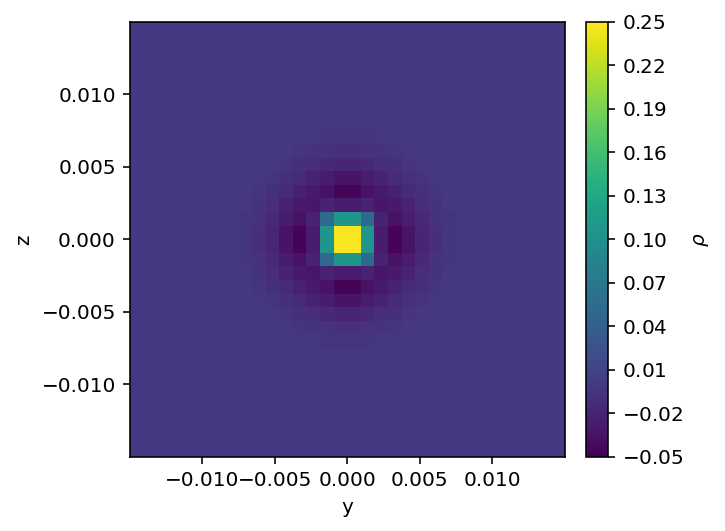

In [8]:
print(f"Trial: {trialfile}")
run_moments = f"{trialpath}/{trialfile}/pfd_moments.xdmf"
vf_moments = viscid.load_file(run_moments, force_reload=True)
print([f.name for f in vf_moments.iter_fields()])

vf_moments.activate_time(0)
vlt.plot(vf_moments["rho_i"] + vf_moments["rho_e"], cbarlabel="$\\rho$");
# vlt.plot((vf_moments["py_e"]**2 + vf_moments["pz_e"]**2)**.5, cbarlabel="$p_e$")
# vlt.plot(vf_moments["tyy_e"] + vf_moments["tzz_e"], cbarlabel = "$T$")
# vlt.plot(vf_moments["rho_e"]);

## Vector Fields
Visualizes a vector field using streamlines.
Change `source` and `label` to specify what field to plot.

- note that time=0 does not exist for most plots
- electric field looks good
- electron momentum is noisy (due to temperature?)

In [4]:
print(f"Trial: {trialfile}")
# select which vector field to plot
source = [vf, vf_moments][1]
label = "p?_e" # replace x/y/z with ?, e.g. "j?_ec"
source.activate_time(0) 

# from https://viscid-hub.github.io/Viscid-docs/docs/master/tutorial/creating_fields.html
half_box_size=.015
n_grid = source[label.replace('?', 'y')].shape[1]
l = np.linspace(-half_box_size, half_box_size, n_grid + 1)

# probably not the best way to do this
fld = viscid.empty([l, l, l], nr_comps=3, layout='interlaced',
                   name="vec field")

# set vector components
for c in ['x', 'y', 'z']:
    fld[c] = source[label.replace('?', c)]

plt.figure(figsize=(5,5))
vlt.streamplot(fld['x=0j'])
# plot2d_quiver(fld)
plt.xlim(-half_box_size, half_box_size)
plt.ylim(-half_box_size, half_box_size)
vlt.auto_adjust_subplots()
plt.show()

Trial: .


NameError: name 'vf' is not defined